#  Cat and Dog Image Classifier using CNN (VGG16 Pretrained Model)

This notebook demonstrates how to build a **binary image classification model** that can distinguish between **cats and dogs** using **Transfer Learning** with the **VGG16** architecture pre-trained on the ImageNet dataset.

We will go through the following steps:
1. Dataset Download (from Kaggle)
2. Data Extraction and Preprocessing
3. Data Visualization
4. Model Building using VGG16
5. Model Training and Evaluation
6. Prediction and Visualization of Results

##  Step 1: Dataset Download and Extraction

We use the **Cat and Dog dataset** available on Kaggle.  
The dataset contains labeled images of cats and dogs that will be used to train and validate our model.

Steps:
- Authenticate and set up the Kaggle API.
- Download the dataset using the dataset ID.
- Unzip the downloaded dataset for further use.


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 68% 149M/218M [00:00<00:00, 1.55GB/s]
100% 218M/218M [00:00<00:00, 989MB/s] 


In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-and-dog.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as pn
import pandas as pandas
import matplotlib.pyplot as plt
import os
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16




##  Step 2: Data Preprocessing

To make the dataset compatible with our deep learning model:
- We use `ImageDataGenerator` to rescale pixel values between 0 and 1.
- Split data into **training** and **validation** sets.
- Apply data augmentation (rotation, zoom, flipping) to prevent overfitting.


In [ ]:
train_path = '/content/training_set/training_set'
test_path = '/content/test_set/test_set'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


##  Step 3: Model Building using VGG16

We use **VGG16** (a pre-trained CNN from ImageNet) as our feature extractor.

### Architecture:
1. Load VGG16 without the top classification layer (`include_top=False`).
2. Freeze all convolutional base layers to retain pre-learned weights.
3. Add custom dense layers for binary classification:
   - Flatten or Global Average Pooling
   - Dense layer with ReLU activation
   - Dropout for regularization
   - Final output layer with sigmoid activation (binary classification)

### Compilation:
- Optimizer: Adam (learning rate = 0.001)
- Loss Function: Binary Crossentropy
- Metric: Accuracy


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# base model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False

# Build model
model = Sequential([
    vgg16,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,297 (56.64 MB)

 Trainable params: 132,097 (516.00 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

## ⚙️ Step 4: Model Training

The model is trained for 8 epochs only using training and validation datasets. you can increase the number of epochs value for the based on your GPU/CPU requirement. in current time i have only GPU that is why i iam just training 8 epochs.

During training:
- Training and validation accuracy progressively improve.
- Validation accuracy reaches above **90%**, showing effective learning.
- Loss consistently decreases, indicating convergence.


**Model shows generalization** (no overfitting, stable improvement).


In [ ]:
model.fit(train_set, epochs=8, validation_data=test_set)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 140s 498ms/step - accuracy: 0.7847 - loss: 0.4545 - val_accuracy: 0.9199 - val_loss: 0.2843
Epoch 2/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 118s 470ms/step - accuracy: 0.8669 - loss: 0.2959 - val_accuracy: 0.8824 - val_loss: 0.2695
Epoch 3/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 116s 463ms/step - accuracy: 0.8750 - loss: 0.2881 - val_accuracy: 0.9011 - val_loss: 0.2309
Epoch 4/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 117s 465ms/step - accuracy: 0.8791 - loss: 0.2837 - val_accuracy: 0.8992 - val_loss: 0.2284
Epoch 5/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 117s 465ms/step - accuracy: 0.8833 - loss: 0.2717 - val_accuracy: 0.8893 - val_loss: 0.2673
Epoch 6/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 117s 465ms/step - accuracy: 0.8893 - loss: 0.2623 - val_accuracy: 0.9145 - val_loss: 0.2001
Epoch 7/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 118s 472ms/step - accuracy: 0.8803 - loss: 0.2722 - val_accuracy: 0.9090 - val_loss: 0.2121
Epoch 8/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 121s 483ms/step - accuracy: 0.8884 - loss: 0

##  Step 5: Model Evaluation and Visualization

We evaluate the trained model on validation data and visualize:
- Accuracy and loss curves
- Sample predictions for cats and dogs
- Correct vs. incorrect classifications

This helps confirm the model’s reliability and robustness.


In [ ]:
history = model.history.history
train_loss = history['loss']
train_accuracy = history['accuracy']
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']

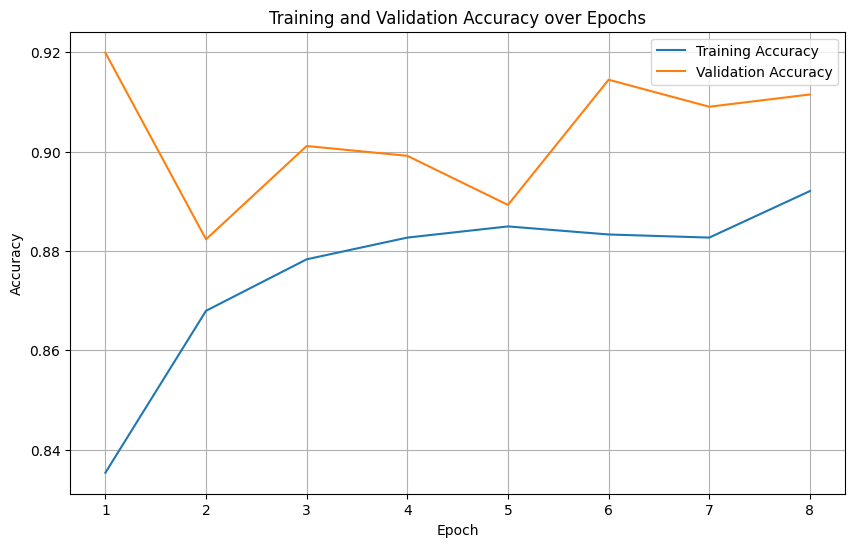

In [ ]:
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

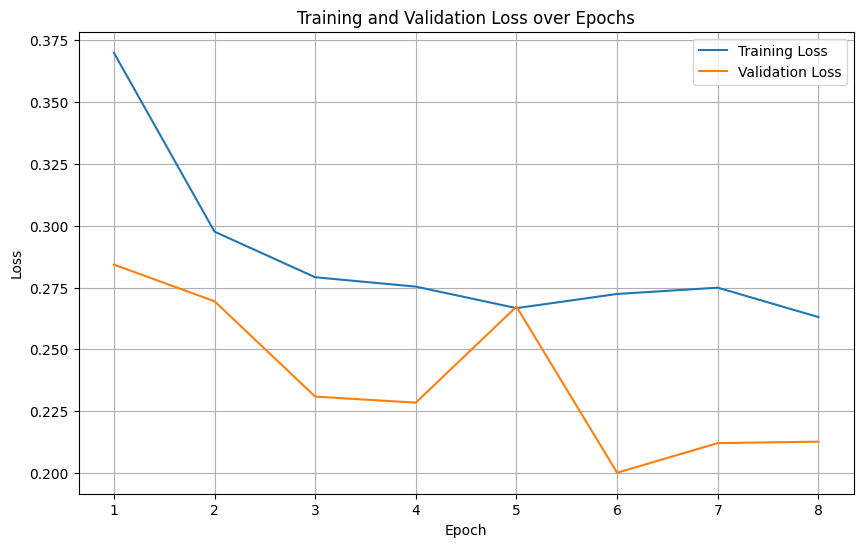

In [ ]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>